In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import glob
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import display
import PIL.Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import matplotlib.patches as patches

# Data Preparation and Loading for Model Training
# 

**Gathering  TFRecord Files for Training and Testing Sets**


In [2]:
train_tfrecord_files = glob.glob('/kaggle/input/object-detection-dataset/train_tfrecords/*.tfrecord')
test_tfrecord_files = glob.glob('/kaggle/input/object-detection-dataset/test_tfrecords/*.tfrecord')
# Verify that files are found
print(f"Found {len(train_tfrecord_files)} training TFRecord files")
print(f"Found {len(test_tfrecord_files)} testing TFRecord files")

Found 1440 training TFRecord files
Found 360 testing TFRecord files


**TFRecord Parsing and Dataset Preparation functions definition for Mobilenetv2 Model**


In [3]:
def parse_tfrecord_function(example_proto):
    """" 
    Parses a single TFRecord example into a formatted example.

    This function takes a serialized TFRecord example and applies a defined schema to parse
    it into a TensorFlow example with a specific structure.

    Parameters:
    - example_proto: A serialized Example to parse.

    Returns:
    - A dictionary of the parsed data, with keys representing the data labels and values as tensors.
    """
    image_feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
    }
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [4]:
def inspect_label_distribution(tfrecord_files):
    """
 This function inspects and prints the distribution of labels within a dataset stored in TFRecord format.
 It iterates over each TFRecord, parses it to extract the label for each example, 
 then calculates and displays the count of each unique label present in the dataset.
  """

    labels = []
    for raw_record in tf.data.TFRecordDataset(tfrecord_files):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        labels.append(example.features.feature['image/object/class/label'].int64_list.value[0])
    print(f"Label distribution: {dict((label, labels.count(label)) for label in set(labels))}")

In [5]:
def prepare_image_and_labels(parsed_record):
    
    """
    Prepares image and labels for model input from a parsed TFRecord example.

    This function decodes the JPEG image from the raw encoded data, resizes it to a 
    standard dimension, and normalizes its pixel values. It also prepares the bounding 
    box coordinates and class labels for the model by normalizing and one-hot encoding 
    them, respectively.

    Args:
        parsed_record: A dictionary containing the parsed data from a TFRecord, including 
        the image data, bounding box coordinates, and class label.

    Returns:
        image: The processed image tensor normalized to [-1, 1].
        A dictionary containing:
            - 'bbox_output': The normalized bounding box coordinates as a tensor.
            - 'class_output': The one-hot encoded class label tensor.
     """ 
    image = tf.image.decode_jpeg(parsed_record['image/encodedrawdata'], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]

    # Normalize bbox coordinates to [0, 1] by image dimensions
    bbox = tf.stack([
        parsed_record['image/object/bbox/ymin'] / 224.0, parsed_record['image/object/bbox/xmin'] / 224.0,
        parsed_record['image/object/bbox/ymax'] / 224.0, parsed_record['image/object/bbox/xmax'] / 224.0
    ], axis=-1)
    
    label = parsed_record['image/object/class/label']
    # depth based on the number of classes
    label = tf.one_hot(label, depth=6)  
    
    return image, {'bbox_output': bbox, 'class_output': label}


* **Scale Uniformity:** I normalized the bounding boxes by image dimensions to maintain uniformity in object scale across all images, enabling the model to interpret object sizes consistently.
* **Adaptation to Input Size:** This normalization approach adapts bounding box coordinates to the model's standard input size, making the learning process more efficient and robust against variations in original image dimensions.
* I Resized images to 224x224 to match MobileNetV2 model's expected input size, optimizing for the network's architecture and performance.

**Check Label distribution**


In [6]:
inspect_label_distribution(train_tfrecord_files)
inspect_label_distribution(test_tfrecord_files)

Label distribution: {0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240}
Label distribution: {0: 60, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


In [7]:
def load_dataset(tfrecord_files, batch_size=32):
    """
    Loads and preprocesses a dataset from TFRecord files.

    Parameters:
    tfrecord_files: List of file paths to TFRecord files.
    batch_size: Number of samples per batch.

    Returns:
    A tf.data.Dataset object ready for training or inference.
    """
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files) # Load TFRecord files
    parsed_dataset = raw_dataset.map(parse_tfrecord_function) # Parse records
    
    # Prepare and batch dataset
    prepared_dataset = parsed_dataset.map(prepare_image_and_labels)
    prepared_dataset = prepared_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return prepared_dataset


* I Chose a batch size of 32 for a balance between efficient GPU memory usage and good model generalization.

**Dividing data into: train, validation, and test sets**

In [16]:
#1. Shuffles the list of training TFRecord files randomly to ensure varied training batches.
np.random.shuffle(train_tfrecord_files)
#2. Determines an 70-30 split for training and validation data
split_size = int(0.7 * len(train_tfrecord_files))
#3. Split the TFRecord files
train_tfrecord_files_split = train_tfrecord_files[:split_size]
val_tfrecord_files_split = train_tfrecord_files[split_size:]

In [9]:
train_dataset = load_dataset(train_tfrecord_files_split)  # Load and preprocess the training dataset
val_dataset = load_dataset(val_tfrecord_files_split)      # Load and preprocess Validation data
test_dataset = load_dataset(test_tfrecord_files)          # Load and preprocess Test data 

# Deep Learning Pipeline: Model Definition and Evaluation

In [21]:
def build_model(num_classes=6, num_bbox_coords=4, dropout_rate=0.5):
    """
    Builds a neural network model for object detection and classification using MobileNetV2 as the backbone.

    This function constructs a model that combines features extracted by MobileNetV2 with two output layers:
    one for bounding box regression and one for class prediction. The model is compiled with appropriate loss
    functions and metrics for each task. Dropout is applied to improve generalization.

    Args:
        num_classes (int): The number of classes for the classification task. Default is 6.
        num_bbox_coords (int): The number of coordinates to predict for each bounding box (usually 4). Default is 4.
        dropout_rate (float): The dropout rate to apply to the feature vectors before the output layers. Default is 0.5.

    Returns:
        tensorflow.keras.models.Model: A compiled Keras model ready for training on object detection and classification tasks.
    """
    # Load MobileNetV2 as the base model with pre-trained weights from ImageNet, excluding its top layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  

    # Added global average pooling and dropout as the next layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)  

    # Branch out from the feature vector to two separate tasks: bounding box regression and class prediction
    # Each branch applies dropout before making predictions to reduce overfitting 
    bbox_features = Dropout(dropout_rate)(x)
    bbox_output = Dense(num_bbox_coords, name='bbox_output')(bbox_features)  # Predict bounding box coordinates

    class_features = Dropout(dropout_rate)(x)
    class_output = Dense(num_classes, activation='softmax', name='class_output')(class_features)  # Predict class

    # Create the model with inputs from the base model and outputs from the two branches
    model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

    # Compile the model with specific loss functions and metrics for each output
    model.compile(optimizer='Adam', 
                  loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
                  metrics={'bbox_output': 'mean_squared_error', 'class_output': 'accuracy'})

    return model

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = build_model(num_classes=6, num_bbox_coords=4, dropout_rate=0.5)

# Early stopping to stop training when the validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-6)

# Fit the model with callbacks
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
      5/Unknown 12s 36ms/step - bbox_output_mean_squared_error: 4.4164 - class_output_accuracy: 0.1106 - loss: 7.9216

W0000 00:00:1711297577.914326      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     35/Unknown 12s 28ms/step - bbox_output_mean_squared_error: 3.7796 - class_output_accuracy: 0.2611 - loss: 6.3862

W0000 00:00:1711297581.985149      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - bbox_output_mean_squared_error: 3.7493 - class_output_accuracy: 0.2693 - loss: 6.3165 - val_bbox_output_mean_squared_error: 0.2118 - val_class_output_accuracy: 0.9757 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - bbox_output_mean_squared_error: 2.2217 - class_output_accuracy: 0.7289 - loss: 2.9734 - val_bbox_output_mean_squared_error: 0.1454 - val_class_output_accuracy: 0.9896 - val_loss: 0.2701 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bbox_output_mean_squared_error: 1.3903 - class_output_accuracy: 0.8440 - loss: 1.8258 - val_bbox_output_mean_squared_error: 0.1239 - val_class_output_accuracy: 0.9965 - val_loss: 0.2011 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - bbox_output_mean_squared_error: 0.9933 - class_output_accuracy: 0.9129 - loss: 1.2668 - val_bbox_output_mean_squared_error: 0.0878 - val_class_output_accuracy: 0.99

**Best Learning Rate:** The learning rate adjustments are made by ReduceLROnPlateau, which reduces the learning rate when a metric has stopped improving. The best performance was noted just before the early stopping, at a learning rate of 8e-06

**Best Epoch:** epoch 47 had the best performance in terms of validation loss before the model began to overfit or stop showing significant improvement on the validation set.

**Metrics at Best Epoch (Epoch 41):**

* Training Bounding Box Output Mean Squared Error: 0.0369
* Training Class Output Accuracy: 99.49%
* Training Loss: 0.0603
* Validation Bounding Box Output Mean Squared Error: 0.0344
* Validation Class Output Accuracy: 99.31%
* Validation Loss: 0.0522

In [24]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"test BBox Output Mean Squared Error: {results[1]}")
print(f"test Class Output Accuracy: {results[2]}")



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - bbox_output_mean_squared_error: 0.0329 - class_output_accuracy: 0.9946 - loss: 0.0619
Test Loss: 0.06383854150772095
test BBox Output Mean Squared Error: 0.03408588096499443
test Class Output Accuracy: 0.9916666746139526


* The test results indicate a high level of accuracy in class prediction and a low error rate in bounding box predictions, showcasing the model's effectiveness despite the challenges in using mAP for evaluation within TensorFlow.
* **Note:** I attempted to evaluate the performance of the bounding box (bbox) detection model using the mean Average Precision (mAP) metric, but was unable to apply it directly within TensorFlow .


**Save the model**

In [26]:
import shutil
import os

model_dir = '/kaggle/working/my_model'

# Clear the output directory if it already exists
if os.path.isdir(model_dir):
    shutil.rmtree(model_dir)

# Save the model using the lower-level TensorFlow API
tf.saved_model.save(model, model_dir)

# Inference on TFRecord Test Samples

**Load the saved model**


In [28]:
loaded_model = tf.saved_model.load('my_model')


In [48]:
serving_fn = loaded_model.signatures['serving_default']


In [39]:
class_names = {
    0: 'crazing',
    1: 'inclusion',
    2: 'patches',
    3: 'pitted_surface',
    4: 'rolled-in_scale',
    5: 'scratches'
}

In [40]:
def parse_tfrecord_function(example_proto):
    """
    Parses a single TFRecord into a formatted example.
    """
    image_feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
    }
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [70]:
def prepare_image_and_labels(parsed_record):
    """
    Decodes and preprocesses image data, extracts bounding box and class label,
    and performs normalization and resizing.
    """
    image = tf.image.decode_jpeg(parsed_record['image/encodedrawdata'], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    bbox = tf.stack([
        parsed_record['image/object/bbox/ymin'] / 224.0, parsed_record['image/object/bbox/xmin'] / 224.0,
        parsed_record['image/object/bbox/ymax'] / 224.0, parsed_record['image/object/bbox/xmax'] / 224.0
    ], axis=-1)
    label = parsed_record['image/object/class/label']
    label = tf.one_hot(label, depth=6)  # Adjust 'depth' based on the number of classes
    return image, {'bbox_output': bbox, 'class_output': label}

In [81]:
def load_and_prepare_dataset(tfrecord_files):
    """
    Loads and prepares a dataset from a list of TFRecord files.

    Args:
        tfrecord_files (list): A list of paths to TFRecord files.

    Returns:
        tf.data.Dataset: A TensorFlow dataset ready for training or evaluation.
    """
    # Load the TFRecord files into a dataset
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

    # Parse the dataset
    parsed_dataset = raw_dataset.map(parse_tfrecord_function)

    # Apply further processing like decoding images, resizing, and normalization
    prepared_dataset = parsed_dataset.map(prepare_image_and_labels).batch(1)

    return prepared_dataset



In [197]:
dataset_for_visualization=load_and_prepare_dataset(['/kaggle/input/object-detection-dataset/test_tfrecords/crazing_crazing_266.jpg.tfrecord',
                                                     '/kaggle/input/object-detection-dataset/test_tfrecords/pitted_surface_pitted_surface_277.jpg.tfrecord',
                                                    '/kaggle/input/object-detection-dataset/test_tfrecords/pitted_surface_pitted_surface_260.jpg.tfrecord',
                
                                                    
            
                              
                                                      ])

In [177]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Parameters:
    box1 -- a list of (ymin, xmin, ymax, xmax) coordinates for the first box
    box2 -- a list of (ymin, xmin, ymax, xmax) coordinates for the second box
    Returns:
    iou -- scalar value of the IoU metric
    """
    y_min_inter = max(box1[0], box2[0])
    x_min_inter = max(box1[1], box2[1])
    y_max_inter = min(box1[2], box2[2])
    x_max_inter = min(box1[3], box2[3])

    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou


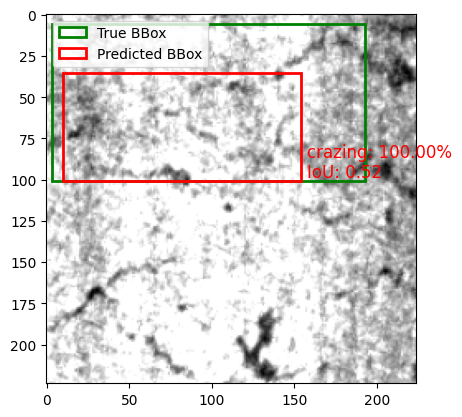

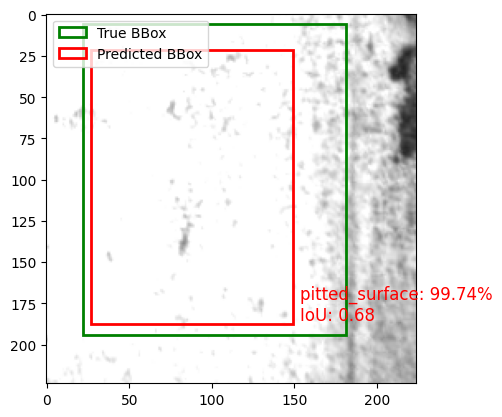

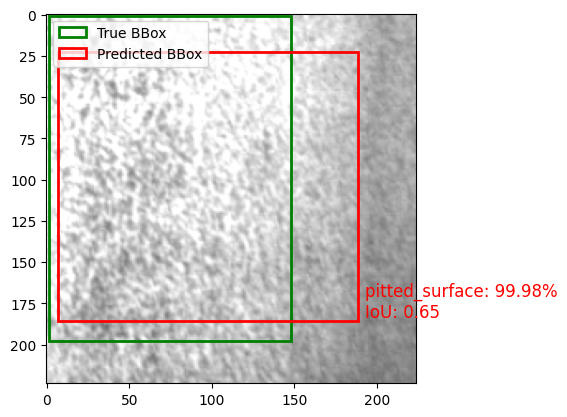

In [201]:
def visualize_prediction(image, true_bbox, pred_bbox, pred_class_idx, confidence):
    
    """
    Visualizes predictions for multiple images from a dataset.
    
    """
    iou = calculate_iou(true_bbox, pred_bbox)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # True BBox
    rect_true = patches.Rectangle((true_bbox[1]*224, true_bbox[0]*224), (true_bbox[3]-true_bbox[1])*224, (true_bbox[2]-true_bbox[0])*224, linewidth=2, edgecolor='g', facecolor='none', label='True BBox')
    ax.add_patch(rect_true)
    
    # Predicted BBox
    rect_pred = patches.Rectangle((pred_bbox[1]*224, pred_bbox[0]*224), (pred_bbox[3]-pred_bbox[1])*224, (pred_bbox[2]-pred_bbox[0])*224, linewidth=2, edgecolor='r', facecolor='none', label='Predicted BBox')
    ax.add_patch(rect_pred)
    
    # Display the class name and confidence for the predicted class
    pred_class_name = class_names[pred_class_idx]
    confidence_pct = confidence * 100
    text_x = pred_bbox[3]*224  # Right edge of the bbox
    text_y = pred_bbox[2]*224  # Bottom edge of the bbox
    plt.text(text_x + 4, text_y, f'{pred_class_name}: {confidence_pct:.2f}%\nIoU: {iou:.2f}', color='red', fontsize=12, verticalalignment='bottom')
    plt.legend(loc='upper left')
    plt.show()

for image, labels in dataset_for_visualization:
    true_bbox = labels['bbox_output'][0].numpy()
    true_class_idx = np.argmax(labels['class_output'][0].numpy())

    # Prepare the image for prediction
    image_for_prediction = tf.expand_dims(image[0], axis=0)
    
    # Predict
    predictions = serving_fn(inputs=image_for_prediction)
    pred_bbox = predictions['output_0'].numpy()[0]
    pred_class_probs = predictions['output_1'].numpy()[0]
    pred_class_idx = np.argmax(pred_class_probs)
    confidence = pred_class_probs[pred_class_idx]

    #function call 
    visualize_prediction(image[0].numpy() + 1.0 / 2, true_bbox, pred_bbox, pred_class_idx, confidence)

**Note:** Throughout the development and experimentation process, various models were evaluated in an effort to improve the Intersection over Union (IoU) results, a crucial metric for assessing the accuracy of bounding box predictions in object detection tasks. Despite these efforts, I  encountered notable challenges related to TensorFlow dependencies, which impacted the seamless exploration and implementation of alternative models. These dependency issues highlight the complexity of managing a deep learning environment and underscore the importance of ensuring compatibility and up-to-date libraries.
Given more time, I could address the TensorFlow dependency issues, paving the way to further enhance model performance and improve Intersection over Union (IoU) outcomes.


